Soft deadline: `30.03.2022 23:59`

In this homework you will understand the fine-tuning procedure and get acquainted with Huggingface Datasets library

In [1]:
! pip install datasets
! pip install transformers

     |████████████████████████████████| 325 kB 5.3 MB/s 
     |████████████████████████████████| 212 kB 37.2 MB/s 
     |████████████████████████████████| 1.1 MB 38.6 MB/s 
     |████████████████████████████████| 67 kB 4.1 MB/s 
     |████████████████████████████████| 136 kB 18.2 MB/s 
     |████████████████████████████████| 127 kB 11.5 MB/s 
     |████████████████████████████████| 271 kB 54.2 MB/s 
     |████████████████████████████████| 94 kB 548 kB/s 
     |████████████████████████████████| 144 kB 11.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 3.8 MB 5.3 MB/s 


For our goals we will use [Datasets](https://huggingface.co/docs/datasets/) library and take `yahoo_answers_topics` dataset - the task of this dataset is to divide documents on 10 topic categories. More detiled information can be found on the dataset [page](https://huggingface.co/datasets/viewer/).


In [2]:
from datasets import load_dataset

In [3]:
dataset = load_dataset('yahoo_answers_topics') # the result is a dataset dictionary of train and test splits in this case

Generating train split:   0%|          | 0/1400000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Dataset yahoo_answers_topics downloaded and prepared to /root/.cache/huggingface/datasets/yahoo_answers_topics/yahoo_answers_topics/1.0.0/b2712a72fde278f1d6e96cc4f485fd89ed2f79ecb231441e13645b53da021902. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'topic', 'question_title', 'question_content', 'best_answer'],
        num_rows: 1400000
    })
    test: Dataset({
        features: ['id', 'topic', 'question_title', 'question_content', 'best_answer'],
        num_rows: 60000
    })
})

In [5]:
 
type(dataset)

datasets.dataset_dict.DatasetDict

In [6]:
len(dataset)

2

In [7]:
dataset.shape

{'test': (60000, 5), 'train': (1400000, 5)}

In [8]:
dataset["train"][0]

{'best_answer': 'Optical mice use an LED and a camera to rapidly capture images of the surface beneath the mouse.  The infomation from the camera is analyzed by a DSP (Digital Signal Processor) and used to detect imperfections in the underlying surface and determine motion. Some materials, such as glass, mirrors or other very shiny, uniform surfaces interfere with the ability of the DSP to accurately analyze the surface beneath the mouse.  \\nSince glass is transparent and very uniform, the mouse is unable to pick up enough imperfections in the underlying surface to determine motion.  Mirrored surfaces are also a problem, since they constantly reflect back the same image, causing the DSP not to recognize motion properly. When the system is unable to see surface changes associated with movement, the mouse will not work properly.',
 'id': 0,
 'question_content': 'or even on some surfaces?',
 'question_title': "why doesn't an optical mouse work on a glass table?",
 'topic': 4}

In [9]:
dataset["test"][0]

{'best_answer': "good communication is what does it.  Can you move beyond small talk and say what's really on your mind.  If you start doing this, my expereince is that potentially good friends will respond or shun you.  Then you know who the really good friends are.",
 'id': 0,
 'question_content': 'How does the spark keep going?',
 'question_title': 'What makes friendship click?',
 'topic': 8}

# Fine-tuning the model** (20 points)

In [10]:
from transformers import (ElectraTokenizer, ElectraForSequenceClassification, get_scheduler, pipeline, ElectraForMaskedLM, ElectraModel)

import torch
from torch.utils.data import DataLoader
from datasets import load_metric
import pandas as pd
import numpy as np
import sklearn 
import matplotlib.pyplot as plt
import time
from IPython.display import HTML

Import model & tokenizer


In [11]:
MODEL_NAME = "google/electra-small-generator"
TOKENIZER_NAME = "google/electra-small-generator"

In [ ]:
#from transformers import ElectraModel, ElectraConfig

# Initializing a ELECTRA electra-base-uncased style configuration
#configuration = ElectraConfig()

# Initializing a model from the electra-base-uncased style configuration
#model = ElectraModel(configuration)

# Accessing the model configuration
#configuration = model.config

In [12]:
tokenizer = ElectraTokenizer.from_pretrained(TOKENIZER_NAME)
model = ElectraForSequenceClassification.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/662 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/51.7M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/electra-small-generator were not used when initializing ElectraForSequenceClassification: ['generator_lm_head.weight', 'generator_predictions.LayerNorm.bias', 'generator_predictions.LayerNorm.weight', 'generator_lm_head.bias', 'generator_predictions.dense.weight', 'generator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-generator and are newly initializ

In [13]:
tokenizer

PreTrainedTokenizer(name_or_path='google/electra-small-generator', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [14]:
model

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_

In [15]:
Test = "Why don't you ask [MASK]?"
Test1 = "What is [MASK]"
Test2 = "Let's talk about [MASK] physics"


In [16]:
pipe = pipeline("fill-mask", model=MODEL_NAME, tokenizer=TOKENIZER_NAME)

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [17]:
pipe(Test)

[{'score': 0.5342992544174194,
  'sequence': "why don't you ask me?",
  'token': 2033,
  'token_str': 'me'},
 {'score': 0.08196018636226654,
  'sequence': "why don't you ask questions?",
  'token': 3980,
  'token_str': 'questions'},
 {'score': 0.04395333677530289,
  'sequence': "why don't you ask them?",
  'token': 2068,
  'token_str': 'them'},
 {'score': 0.04017288610339165,
  'sequence': "why don't you ask why?",
  'token': 2339,
  'token_str': 'why'},
 {'score': 0.030024440959095955,
  'sequence': "why don't you ask yourself?",
  'token': 4426,
  'token_str': 'yourself'}]

In [18]:
pipe(Test1)

[{'score': 0.9262322783470154,
  'sequence': 'what is?',
  'token': 1029,
  'token_str': '?'},
 {'score': 0.05156780779361725,
  'sequence': 'what is.',
  'token': 1012,
  'token_str': '.'},
 {'score': 0.021510401740670204,
  'sequence': 'what is!',
  'token': 999,
  'token_str': '!'},
 {'score': 0.0001196492012240924,
  'sequence': 'what is -',
  'token': 1011,
  'token_str': '-'},
 {'score': 0.00010928419214906171,
  'sequence': 'what is "',
  'token': 1000,
  'token_str': '"'}]

In [19]:
pipe(Test2)

[{'score': 0.24027501046657562,
  'sequence': "let's talk about quantum physics",
  'token': 8559,
  'token_str': 'quantum'},
 {'score': 0.21258601546287537,
  'sequence': "let's talk about theoretical physics",
  'token': 9373,
  'token_str': 'theoretical'},
 {'score': 0.056394025683403015,
  'sequence': "let's talk about particle physics",
  'token': 10811,
  'token_str': 'particle'},
 {'score': 0.0332079641520977,
  'sequence': "let's talk about real physics",
  'token': 2613,
  'token_str': 'real'},
 {'score': 0.022627945989370346,
  'sequence': "let's talk about mathematical physics",
  'token': 8045,
  'token_str': 'mathematical'}]

Convert best_answer to the input tokens 

In [20]:
import tensorflow as tf

In [21]:
def tokenize_function(examples):
    return tokenizer(examples["best_answer"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True) # 45 mins

  0%|          | 0/1400 [00:00<?, ?ba/s]

  0%|          | 0/60 [00:00<?, ?ba/s]

In [22]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'topic', 'question_title', 'question_content', 'best_answer', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1400000
    })
    test: Dataset({
        features: ['id', 'topic', 'question_title', 'question_content', 'best_answer', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 60000
    })
})

In [23]:
tokenized_datasets.set_format("torch")
tokenized_datasets = tokenized_datasets.remove_columns(['question_title', 'question_content', 'best_answer'])

In [24]:
tokenized_datasets = tokenized_datasets.remove_columns(['id'])

In [25]:
tokenized_datasets = tokenized_datasets.rename_column("topic", "labels")

In [26]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=26).select(range(5000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=26).select(range(5000))

In [27]:
small_train_dataset

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 5000
})

In [28]:
small_eval_dataset

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 5000
})

In [29]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=8)

In [30]:
from transformers import AutoModelForSequenceClassification

mini_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=10)

Some weights of the model checkpoint at google/electra-small-generator were not used when initializing ElectraForSequenceClassification: ['generator_lm_head.weight', 'generator_predictions.LayerNorm.bias', 'generator_predictions.LayerNorm.weight', 'generator_lm_head.bias', 'generator_predictions.dense.weight', 'generator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-generator and are newly initializ

Defining Optimizer & Scheduler 

Parameters

1. Learning rate = 5e-5

2. EPOCH = 5

3. Batch size = 8

In [31]:
from torch.optim import AdamW

optimizer = AdamW(mini_model.parameters(), lr=5e-5)

In [32]:
from transformers import get_scheduler

num_epochs = 5
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [33]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
mini_model.to(device)

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_

Training

In [34]:
from tqdm import tqdm
record = []
#progress_bar = tqdm(range(num_training_steps))

mini_model.train()
for epoch in tqdm(range(num_epochs)):
    smallloss = []
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = mini_model(**batch)
        loss = outputs.loss
        loss.backward()
        smallloss.append(loss)
        optimizer.step()
        #smallloss.append(loss)
        lr_scheduler.step()
        optimizer.zero_grad()
    record.append(torch.mean(torch.tensor(smallloss)))
    print(f"Epoch Number {epoch}\n Current loss {torch.mean(torch.tensor(smallloss))}")

 20%|██        | 1/5 [03:51<15:26, 231.53s/it]

Epoch Number 0
 Current loss 1.8062132596969604


 40%|████      | 2/5 [07:30<11:12, 224.04s/it]

Epoch Number 1
 Current loss 1.3272665739059448


 60%|██████    | 3/5 [11:09<07:23, 221.65s/it]

Epoch Number 2
 Current loss 1.0992131233215332


 80%|████████  | 4/5 [14:47<03:40, 220.51s/it]

Epoch Number 3
 Current loss 0.9207884669303894


100%|██████████| 5/5 [18:28<00:00, 221.63s/it]

Epoch Number 4
 Current loss 0.7963966131210327


In [35]:
smallloss[0:5]

[tensor(0.8466, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(1.1318, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(1.0324, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(1.0706, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.5068, device='cuda:0', grad_fn=<NllLossBackward0>)]

In [36]:
record

[tensor(1.8062),
 tensor(1.3273),
 tensor(1.0992),
 tensor(0.9208),
 tensor(0.7964)]

Plotting Loss vs Rating

Text(0, 0.5, 'Loss')

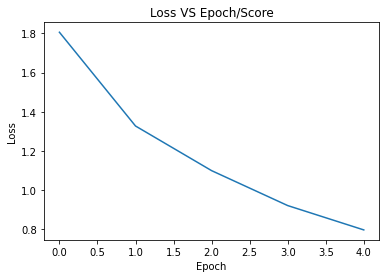

In [37]:
plt.plot(record)
plt.title("Loss VS Epoch/Score")
plt.xlabel("Epoch")
plt.ylabel("Loss")

Result in Terms of Weighted Score

In [38]:
metric = load_metric("accuracy")
mini_model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = mini_model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

{'accuracy': 0.585}

In [39]:
metric = load_metric("f1")
mini_model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = mini_model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute(average = 'weighted')

{'f1': 0.582154849403427}

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
mini_model.save_pretrained("/content/drive/MyDrive/Colab Notebooks/Trained model")

In [42]:
new_model = ElectraForMaskedLM.from_pretrained("/content/drive/MyDrive/Colab Notebooks/Trained model")

Some weights of the model checkpoint at /content/drive/MyDrive/Colab Notebooks/Trained model were not used when initializing ElectraForMaskedLM: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
- This IS expected if you are initializing ElectraForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForMaskedLM were not initialized from the model checkpoint at /content/drive/MyDrive/Colab Notebooks/Trained model and are newly initialized: ['generator_lm_head.weight', 'generator_predictions.LayerNorm.bias', 'generator_predictions.LayerNorm.weight

In [43]:
newpipe = pipeline('fill-mask', model=new_model, tokenizer=TOKENIZER_NAME)

Test = "Why don't you ask [MASK]?" 

Test1 = "What is [MASK]"

Test2 = "Let's talk about [MASK] physics"


New Model Test output 

In [44]:
newpipe(Test)

[{'score': 0.0002687738451641053,
  'sequence': "why don't you askuated?",
  'token': 16453,
  'token_str': '##uated'},
 {'score': 0.0002310172567376867,
  'sequence': "why don't you ask charged?",
  'token': 5338,
  'token_str': 'charged'},
 {'score': 0.00022838052245788276,
  'sequence': "why don't you ask galaxies?",
  'token': 21706,
  'token_str': 'galaxies'},
 {'score': 0.00022550299763679504,
  'sequence': "why don't you ask credits?",
  'token': 6495,
  'token_str': 'credits'},
 {'score': 0.00022433856793213636,
  'sequence': "why don't you askmpt?",
  'token': 27718,
  'token_str': '##mpt'}]

In [45]:
newpipe(Test1)

[{'score': 0.0003349150938447565,
  'sequence': 'what is regis',
  'token': 20588,
  'token_str': 'regis'},
 {'score': 0.0002977666154038161,
  'sequence': 'what isholes',
  'token': 19990,
  'token_str': '##holes'},
 {'score': 0.0002952291688416153,
  'sequence': 'what is transmitters',
  'token': 26288,
  'token_str': 'transmitters'},
 {'score': 0.0002929133188445121,
  'sequence': 'what is loosened',
  'token': 22456,
  'token_str': 'loosened'},
 {'score': 0.00028961850330233574,
  'sequence': 'what isosomal',
  'token': 27642,
  'token_str': '##osomal'}]

In [46]:
newpipe(Test2)

[{'score': 0.00037074240390211344,
  'sequence': "let's talk aboutobe physics",
  'token': 20891,
  'token_str': '##obe'},
 {'score': 0.0003314380592200905,
  'sequence': "let's talk aboutator physics",
  'token': 8844,
  'token_str': '##ator'},
 {'score': 0.00030386250000447035,
  'sequence': "let's talk aboutrator physics",
  'token': 16259,
  'token_str': '##rator'},
 {'score': 0.00029139575781300664,
  'sequence': "let's talk about enhancement physics",
  'token': 22415,
  'token_str': 'enhancement'},
 {'score': 0.00028835245757363737,
  'sequence': "let's talk aboutiser physics",
  'token': 17288,
  'token_str': '##iser'}]

The predictions of the newer model are worse than the orginal model. It produces words that in a very broad specturm. With the current parameters an F1 Score of 0.58 was attained. The worse score may be due to shuffled and crossweighted samples, or due to that combination of Parameters. It can be improved with a different set of parameters, by retraining with new layers from base model may impact postitivley. 


#Tune the training hyperparameters (and write down your results).

Altered Hyperparameters
1. Learning rate = 5e-5

2. EPOCH = 5

3. Batch size = 16

In [47]:
mini_model2 = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=10)

Some weights of the model checkpoint at google/electra-small-generator were not used when initializing ElectraForSequenceClassification: ['generator_lm_head.weight', 'generator_predictions.LayerNorm.bias', 'generator_predictions.LayerNorm.weight', 'generator_lm_head.bias', 'generator_predictions.dense.weight', 'generator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-generator and are newly initializ

In [ ]:
###

In [48]:
for param in mini_model2.electra.parameters():
      param.requires_grad = False

In [49]:
train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=16)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=16)

In [50]:
optimizer = AdamW(mini_model2.parameters(), lr=5e-5)

In [51]:
num_epochs = 5
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [52]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
mini_model2.to(device)

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_

In [53]:
record2 = []
#mini_model2.to(device)

mini_model2.train()
for epoch in tqdm(range(num_epochs)):
    smallloss = []
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = mini_model2(**batch)
        loss = outputs.loss
        loss.backward()
        smallloss.append(loss)
        optimizer.step()
        #smallloss.append(loss)
        lr_scheduler.step()
        optimizer.zero_grad()
    record2.append(torch.mean(torch.tensor(smallloss)))
    print(f"Epoch Number {epoch}\n Current loss {torch.mean(torch.tensor(smallloss))}")

 20%|██        | 1/5 [01:16<05:07, 76.98s/it]

Epoch Number 0
 Current loss 2.3005027770996094


 40%|████      | 2/5 [02:33<03:50, 76.67s/it]

Epoch Number 1
 Current loss 2.2903027534484863


 60%|██████    | 3/5 [03:49<02:33, 76.56s/it]

Epoch Number 2
 Current loss 2.2798073291778564


 80%|████████  | 4/5 [05:06<01:16, 76.49s/it]

Epoch Number 3
 Current loss 2.2726542949676514


100%|██████████| 5/5 [06:22<00:00, 76.53s/it]

Epoch Number 4
 Current loss 2.268251895904541


Text(0, 0.5, 'Loss')

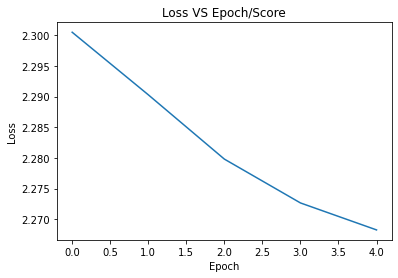

In [54]:
plt.plot(record2)
plt.title("Loss VS Epoch/Score")
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [55]:
mini_model2.to(device)
metric = load_metric("accuracy")
mini_model2.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = mini_model2(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

{'accuracy': 0.273}

In [56]:
metric = load_metric("f1")
mini_model2.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = mini_model2(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute(average = 'weighted')

{'f1': 0.20350591501104473}

In [57]:
mini_model2.save_pretrained("/content/drive/MyDrive/Colab Notebooks/Trained model")

In [58]:
new_model2 = ElectraForMaskedLM.from_pretrained("/content/drive/MyDrive/Colab Notebooks/Trained model")

Some weights of the model checkpoint at /content/drive/MyDrive/Colab Notebooks/Trained model were not used when initializing ElectraForMaskedLM: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
- This IS expected if you are initializing ElectraForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForMaskedLM were not initialized from the model checkpoint at /content/drive/MyDrive/Colab Notebooks/Trained model and are newly initialized: ['generator_lm_head.weight', 'generator_predictions.LayerNorm.bias', 'generator_predictions.LayerNorm.weight

In [59]:
newpipe2 = pipeline('fill-mask', model=new_model2, tokenizer=TOKENIZER_NAME)

Test = "Why don't you ask [MASK]?" 

Test1 = "What is [MASK]"

Test2 = "Let's talk about [MASK] physics"


New Model Test output 

In [60]:
newpipe2(Test)

[{'score': 0.0003528367087710649,
  'sequence': "why don't you askcier?",
  'token': 19562,
  'token_str': '##cier'},
 {'score': 0.00034862427855841815,
  'sequence': "why don't you ask manson?",
  'token': 21440,
  'token_str': 'manson'},
 {'score': 0.00027888352633453906,
  'sequence': "why don't you ask whitaker?",
  'token': 27049,
  'token_str': 'whitaker'},
 {'score': 0.0002677396696526557,
  'sequence': "why don't you ask stills?",
  'token': 26105,
  'token_str': 'stills'},
 {'score': 0.00025031736004166305,
  'sequence': "why don't you ask bernardo?",
  'token': 21175,
  'token_str': 'bernardo'}]

In [61]:
newpipe2(Test1)

[{'score': 0.00035167703754268587,
  'sequence': 'what iswee',
  'token': 28394,
  'token_str': '##wee'},
 {'score': 0.00029217914561741054,
  'sequence': 'what is facebook',
  'token': 9130,
  'token_str': 'facebook'},
 {'score': 0.0002693442511372268,
  'sequence': 'what is espana',
  'token': 20678,
  'token_str': 'espana'},
 {'score': 0.0002669630339369178,
  'sequence': 'what istagram',
  'token': 23091,
  'token_str': '##tagram'},
 {'score': 0.00026366146630607545,
  'sequence': 'what is telugu',
  'token': 12180,
  'token_str': 'telugu'}]

In [62]:
newpipe2(Test2)

[{'score': 0.00036003044806420803,
  'sequence': "let's talk about mp physics",
  'token': 6131,
  'token_str': 'mp'},
 {'score': 0.0003358162648510188,
  'sequence': "let's talk about exhibit physics",
  'token': 8327,
  'token_str': 'exhibit'},
 {'score': 0.00030861125560477376,
  'sequence': "let's talk about ndp physics",
  'token': 21915,
  'token_str': 'ndp'},
 {'score': 0.0003050363447982818,
  'sequence': "let's talk about finalist physics",
  'token': 9914,
  'token_str': 'finalist'},
 {'score': 0.000280279025901109,
  'sequence': "let's talk about contestant physics",
  'token': 10832,
  'token_str': 'contestant'}]

It is observed that the model has further deprecited with variation in parameters, it tries to relate and make sense but loses out